### ニューラルネットワーク

ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用します。各種ライブラリやサイトからダウンロードできますが、ここでは深層学習フレームワークのKerasを用います。以下のコードを実行すればデータセットをダウンロードし、展開まで行えます。



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import statistics
from scipy import stats
import collections
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold


In [114]:
import keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

《MNISTとは？》

画像分類のための定番データセットで、手書き数字認識を行います。このデータセットには訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベルが含まれています。


《画像データとは？》

デジタル画像は点の集合で、これをピクセルと呼びます。一般的に白黒画像であればピクセルには0〜255の値が含まれます。一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われます。0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できます。

平滑化

(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。全てのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現します。



In [115]:
# データを平滑化する。
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

#### 画像データの可視化

画像データを可視化します。plt.imshowに渡します。

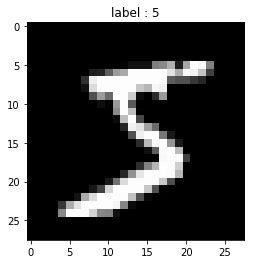

In [116]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

《発展的話題》

画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。

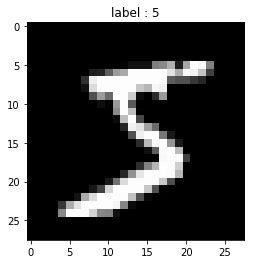

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [117]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。

plt.imshow(image, 'gray', vmin = 0, vmax = 255)

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておきましょう。


#### 前処理
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。

In [118]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。



In [119]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


さらに、訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


### ミニバッチ処理


これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。


今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練データを一度全て見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。


これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [121]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### ニューラルネットワークスクラッチ

ニューラルネットワークのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


今回は多クラス分類を行う3層のニューラルネットワークを作成します。層の数などは固定した上でニューラルネットワークの基本を学びます。次のSprintで層を自由に変えられる設計にしていきます。


以下に雛形を用意してあります。このScratchSimpleNeuralNetrowkClassifierクラスにコードを書き加えていってください。



In [122]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, verbose = True):
        self.verbose = verbose
        self.L_log = []
        self.L_val_log = []
        batch_size = 80
        n_features = 784
        n_nodes1 = 400
        n_nodes2 = 200
        n_output = 10

        sigma = 0.01 # ガウス分布の標準偏差

        self.W1 = sigma * np.random.randn(n_features, n_nodes1) # 第1層目の重み　（係数）
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2) # 第2層目の重み（係数）
        self.W3 = sigma * np.random.randn(n_nodes2, n_output) # 第3層目の重み　（係数）
        self.B1 = sigma * np.random.randn(n_nodes1) # 第1層目の重み　（バイアス）
        self.B2 = sigma * np.random.randn(n_nodes2) # 第2層目の重み　（バイアス）
        self.B3 = sigma * np.random.randn(n_output) # 第3層目の重み　（バイアス）
    
    def fit(self, X, y, X_val=None, y_val=None, rate=0.01, epoch=2):
        
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
            """
        self.rate = rate
        self.X = X
        self.y = y # yはすでにone-hot済の正解ラベル
        
        iteration = 600 #訓練データ48000枚 / バッチサイズ80(20から変更)
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=80) # ミニバッチ生成関数のインスタンス生成
            K = 0
            for self.X, self.y in get_mini_batch: # ミニバッチ単位でフォーワード、バックプロパの学習をイテレーション分繰り返す。
                self.forward()
                self.backpro()
                K += 1
                if self.verbose:
                    Z3 = self.predict(self.X)[1] # 学習結果元にトレインデータの予測
                    L = self.entropy(Z3,self.y)  # トレインデータのエントロピー計算
                    self.L_log.append(L)         # エントロピー結果を記録しておく
                    print("(train) iter数 ： {} => cross entropy : {}".format(K,L))
                if X_val is not None:
                    index = random.sample(range(len(X_val)), k=80)
                    Z3_val = self.predict(X_val[index])[1]          # 学習結果元にvalデータの予測
                    L_val = self.entropy(Z3_val,y_val[index])  # valデータのエントロピー計算
                    self.L_val_log.append(L_val)        # エントロピー結果を記録しておく
                    print("  (val) iter数 ： {} => cross entropy : {}".format(K,L_val))
                      
    def predict(self, X):   # これまで学習したW1〜3, B1〜3,を使いフォーワードで入力から出力（確率が最も高いラベル）を計算
        # 1層目
        A1 = X @ self.W1 + self.B1          
        Z1 = self.activation(A1,"sigmoid")
        
        # 2層目
        A2 = Z1 @ self.W2 + self.B2
        Z2 = self.activation(A2,"sigmoid")
        
        # 3層目
        A3 = Z2 @ self.W3 + self.B3
        Z3 = self.softmax(A3)
        
        return np.argmax(Z3, axis=1) , Z3           
    
    def forward(self):    # フォーワードで入力から出力（確率が最も高いラベル）を計算する。
        
        # 1層目
        self.A1 = self.X @ self.W1 + self.B1
        self.Z1 = self.activation(self.A1,"sigmoid")
        
        # 2層目
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.activation(self.A2,"sigmoid")
        
        # 3層目
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
        
    def backpro(self):  # フォーワードで求まった出力（予測値）を元に誤差を出し、そこから、逆伝搬で各層の重みの偏微分を算出し勾配降下で重みを更新
        
        # 3層目
        grad_A3 = self.Z3 - self.y
        grad_B3 = np.sum(grad_A3, axis=0)
        grad_W3 = self.Z2.T @ grad_A3
        grad_Z2 = grad_A3 @ self.W3.T
        
        # 2層目
        grad_A2 = grad_Z2 * (1-np.tanh(self.A2)**2)
        grad_B2 = np.sum(grad_A2, axis=0)
        grad_W2 = self.Z1.T @ grad_A2
        grad_Z1 = grad_A2 @ self.W2.T
        
        # 1層目
        grad_A1 = grad_Z1 * (1-np.tanh(self.A1)**2)
        grad_B1 = np.sum(grad_A1, axis=0)
        grad_W1 = self.X.T @ grad_A1
        
        # 上記計算結果を元に各層の重み（係数W,バイアスB）を更新
        self.W1 -= self.rate * grad_W1
        self.B1 -= self.rate * grad_B1
        self.W2 -= self.rate * grad_W2
        self.B2 -= self.rate * grad_B2
        self.W3 -= self.rate * grad_W3
        self.B3 -= self.rate * grad_B3
        
    
    def entropy(self,Z3, y_one_hot_label):  # 各ラベルの予測確率と正解ラベル（onehot）を引数にクロスエントロピを計算。その際、バッチ単位で平均したものを出力
        batch_size = len(Z3)
        L = -1/batch_size*np.sum(y_one_hot_label*np.log(Z3))
        return L
    
    def activation(self, A, model): # 使用する活性化関数を関数化しておく。
        if model == "sigmoid" :
            return 1/(1+np.exp(-A))
        
        if model == "tanh" :
            return np.tanh(A)
    
    def softmax(self,A3):       # 使用するソフトマックス関数を関数化しておく
        batch_size = len(A3)
        output = 10
        Z3 = np.zeros((batch_size,output))
        for i in range(batch_size):
            for k in range (output):
                Z3[i][k] = np.exp(A3)[i][k]/np.sum(np.exp(A3), axis=1)[i]
        return Z3
                          

In [98]:
model1 = ScratchSimpleNeuralNetrowkClassifier()
model1.fit(X_train, y_train, X_val, y_val)

(train) iter数 ： 1 => cross entropy : 2.369409516212136
  (val) iter数 ： 1 => cross entropy : 2.4048887582627083
(train) iter数 ： 2 => cross entropy : 2.8901129668866137
  (val) iter数 ： 2 => cross entropy : 3.424380806902987
(train) iter数 ： 3 => cross entropy : 2.49150913475075
  (val) iter数 ： 3 => cross entropy : 2.8218648311896715
(train) iter数 ： 4 => cross entropy : 2.306082164212729
  (val) iter数 ： 4 => cross entropy : 2.3829798138531224
(train) iter数 ： 5 => cross entropy : 2.3182175769546083
  (val) iter数 ： 5 => cross entropy : 2.303272652038395
(train) iter数 ： 6 => cross entropy : 2.3015250884069363
  (val) iter数 ： 6 => cross entropy : 2.3103982737484308
(train) iter数 ： 7 => cross entropy : 2.3013573404184995
  (val) iter数 ： 7 => cross entropy : 2.3031039885889757
(train) iter数 ： 8 => cross entropy : 2.2949753143641525
  (val) iter数 ： 8 => cross entropy : 2.304392976217762
(train) iter数 ： 9 => cross entropy : 2.1907009390210024
  (val) iter数 ： 9 => cross entropy : 2.3399479025030407

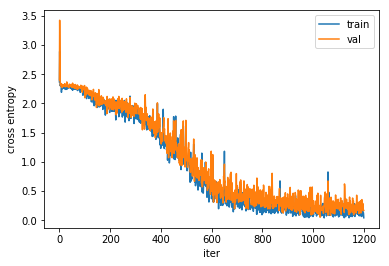

In [101]:
plt.plot(model1.L_log,label="train")
plt.plot(model1.L_val_log,label="val")
plt.xlabel("iter")
plt.ylabel("cross entropy")
plt.legend()

In [102]:
# 予測
y_pred = model1.predict(X_val)[0]

In [106]:
# onehot化していたのでラベルに直す
y_val = np.argmax(y_val, axis=1)

In [108]:
# 正解率
accuracy_score(y_val,y_pred)

0.9309166666666666

今回では、バッチサイズ80で600iterを1エポックとし２エポック学習した。結果、上記グラフの通り、train,valデータ共にcross entropyが低くなり、適切に学習させる事ができた。
600iter(1エポックに相当)である程度下り、あとは飽和しているため、600iter(1エポックに相当)はデータ48000データを学習させればある程度学習させ適切な予測ができると考えられる。
今回はラベル10個（0〜9）なので1ラベルあたり4800で約5000個あれば事足りると思われる。
（このデータセットもこのディープラーニングの学習を見越して適切な枚数のデータを用意しているを推定）

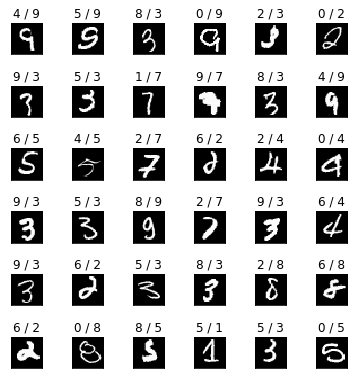

In [109]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

<BarContainer object of 10 artists>

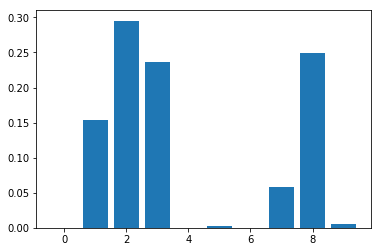

In [110]:
# 正解ラベル：３、予測（確率が最も高い）：２　の予測確率分布の事例
true_false = y_pred!=y_val
plt.bar([i for i in range(10)], pred[1][true_false][4])

予測が間違っているデータ（文字）を確認すると、例えば　”０と９”の共にマルがあるもの　や　”２と７”のようになんとなく形が似ているものである。これらは予測確率を見ると、確かに正解ラベルにもある程度予測の確率はでているが、それ以上に他の間違いやすいラベルに最も高い確率を返している事がわかった。（上記に一事例表示）
機械学習エンジニアは、このような間違いやすい傾向を把握すると共にこの間違いやすい場合にも適切に予測できるアルゴリズムを考えることも必要になってくると考える。

**ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。**

### 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

```python

    def __init__(self, verbose = True):
        self.verbose = verbose
        self.L_log = []
        self.L_val_log = []
        batch_size = 80
        n_features = 784
        n_nodes1 = 400
        n_nodes2 = 200
        n_output = 10

        sigma = 0.01 # ガウス分布の標準偏差

        self.W1 = sigma * np.random.randn(n_features, n_nodes1) # 第1層目の重み　（係数）
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2) # 第2層目の重み（係数）
        self.W3 = sigma * np.random.randn(n_nodes2, n_output) # 第3層目の重み　（係数）
        self.B1 = sigma * np.random.randn(n_nodes1) # 第1層目の重み　（バイアス）
        self.B2 = sigma * np.random.randn(n_nodes2) # 第2層目の重み　（バイアス）
        self.B3 = sigma * np.random.randn(n_output) # 第3層目の重み　（バイアス）
```

#### 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

#### 「1層目」


A
1
=
X
⋅
W
1
+
B
1

X
 : 特徴量ベクトル (batch_size, n_features)


W
1
 : 1層目の重み (n_features, n_nodes1)


B
1
 : 1層目のバイアス (n_nodes1,)


A
1
 : 出力 (batch_size, n_nodes1)



#### 「1層目の活性化関数」


Z
1
=
f
(
A
1
)

f
(
)
 : 活性化関数


Z
1
 出力 (batch_size, n_nodes1)

#### 「2層目」


A
2
=
Z
1
⋅
W
2
+
B
2

W
2
 : 2層目の重み (n_nodes1, n_nodes2)


B
2
 : 2層目のバイアス (n_nodes2,)


A
2
 : 出力 (batch_size, n_nodes2)

#### 「2層目の活性化関数」


Z
2
=
f
(
A
2
)

f
(
)
 : 活性化関数


Z
2
 出力 (batch_size, n_nodes2)

#### 「3層目（出力層）」


A
3
=
Z
2
⋅
W
3
+
B
3

W
3
 : 3層目の重み (n_nodes2, n_output)


B
3
 : 3層目のバイアス (n_output,)


A
3
 : 出力 (batch_size, n_output)

#### 「3層目の活性化関数」


Z
3
=
s
o
f
t
m
a
x
(
A
3
)

s
o
f
t
m
a
x
(
)
 : ソフトマックス関数


Z
3
 出力 (batch_size, n_output)


Z
3
 は各ラベル（0〜9）に対する確率の配列である。

```python
def forward(self):    # フォーワードで入力から出力（確率が最も高いラベル）を計算する。
        
        # 1層目
        self.A1 = self.X @ self.W1 + self.B1
        self.Z1 = self.activation(self.A1,"sigmoid")
        
        # 2層目
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.activation(self.A2,"sigmoid")
        
        # 3層目
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)

```

### 活性化関数（フォワードプロバゲーション）


活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。


**「シグモイド関数」**


f
(
Z
)
=
s
i
g
m
o
i
d
(
A
)
=
1
1
+
e
x
p
(
−
A
)

指数関数 
e
x
p
(
−
A
)
 の計算はnp.expを使用してください。
 
 **「ハイパボリックタンジェント関数」**


次の数式で表されますが、np.tanhひとつで実現できます。


f
(
Z
)
=
t
a
n
h
(
A
)
=
e
x
p
(
A
)
−
e
x
p
(
−
A
)
e
x
p
(
A
)
+
e
x
p
(
−
A
)

＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。

```python
def activation(self, A, model): # 使用する活性化関数を関数化しておく。
        if model == "sigmoid" :
            return 1/(1+np.exp(-A))
        
        if model == "tanh" :
            return np.tanh(A)
```

#### ソフトマックス関数


ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。


次の数式です。


Z
3
_
k
=
e
x
p
(
A
3
_
k
)
∑
n
c
i
=
1
e
x
p
(
A
3
_
i
)

Z
3
k
 : 
k
 番目のクラスの確率ベクトル (batch_size,)


A
3
k
 : 
k
 番目のクラスにあたる前の層からのベクトル (batch_size,)


n
c
 : クラスの数、n_output。今回のMNISTでは10。


分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に 
k
 番目のクラスを持ってくることで、 
k
 番目のクラスである確率が求まります。


これを10クラス分計算し、合わせたものが 
Z
3
 です。



```python
def softmax(self,A3):       # 使用するソフトマックス関数を関数化しておく
        batch_size = len(A3)
        output = 10
        Z3 = np.zeros((batch_size,output))
        for i in range(batch_size):
            for k in range (output):
                Z3[i][k] = np.exp(A3)[i][k]/np.sum(np.exp(A3), axis=1)[i]
        return Z3
```

### 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。


L
=
−
1
n
b
n
b
∑
j
  
n
c
∑
k
 
y
j
k
l
o
g
(
z
3
_
j
k
)

$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）


$n_{b}$ : バッチサイズ、batch_size


$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）


サンプル1つあたりの誤差が求まります。



```python
def entropy(self,Z3, y_one_hot_label):  # 各ラベルの予測確率と正解ラベル（onehot）を引数にクロスエントロピを計算。その際、バッチ単位で平均したものを出力
        batch_size = len(Z3)
        L = -1/batch_size*np.sum(y_one_hot_label*np.log(Z3))
        return L
```

### 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。


数式を以下に示します。


まず、i層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。


$$𝑊′𝑖=𝑊𝑖−𝛼∂𝐿∂𝑊𝑖𝐵′𝑖=𝐵𝑖−𝛼∂𝐿∂𝐵𝑖$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。


この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。


勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。


「3層目」


$$∂𝐿∂𝐴3=𝑍3−𝑌∂𝐿∂𝐵3=∑𝑗𝑛𝑏∂𝐿∂𝐴3_𝑗∂𝐿∂𝑊3=𝑍𝑇2⋅∂𝐿∂𝐴3∂𝐿∂𝑍2=∂𝐿∂𝐴3⋅𝑊𝑇3$$

$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)


$\frac{\partial L}{\partial A_{3_j}}$ : j番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)


$Y$ : 正解ラベル (batch_size, n_output)


$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)


$W_3$ : 3層目の重み (n_nodes2, n_output)


「2層目」


$$∂𝐿∂𝐴2=∂𝐿∂𝑍2⊙{1−𝑡𝑎𝑛ℎ2(𝐴2)}∂𝐿∂𝐵2=∑𝑗𝑛𝑏∂𝐿∂𝐴2_𝑗∂𝐿∂𝑊2=𝑍𝑇1⋅∂𝐿∂𝐴2∂𝐿∂𝑍1=∂𝐿∂𝐴2⋅𝑊𝑇2$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$\frac{\partial L}{\partial A_{2_j}}$ : j番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$A_2$ : 2層目の出力 (batch_size, n_nodes2)


$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)


$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


「1層目」


$$∂𝐿∂𝐴1=∂𝐿∂𝑍1⊙{1−𝑡𝑎𝑛ℎ2(𝐴1)}∂𝐿∂𝐵1=∑𝑗𝑛𝑏∂𝐿∂𝐴1_𝑗∂𝐿∂𝑊1=𝑋𝑇⋅∂𝐿∂𝐴1$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$\frac{\partial L}{\partial A_{1_j}}$ : j番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)


$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$A_1$ : 1層目の出力 (batch_size, n_nodes1)


$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)


《補足》


活性化関数にシグモイド関数を使用した場合は、次のようになります。


$$∂𝐿∂𝐴2=∂𝐿∂𝑍2⊙{1−𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐴2)}𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐴2)∂𝐿∂𝐴1=∂𝐿∂𝑍1⊙{1−𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐴1)}𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐴1)$$

```python
def backpro(self):  # フォーワードで求まった出力（予測値）を元に誤差を出し、そこから、逆伝搬で各層の重みの偏微分を算出し勾配降下で重みを更新
        
        # 3層目
        grad_A3 = self.Z3 - self.y
        grad_B3 = np.sum(grad_A3, axis=0)
        grad_W3 = self.Z2.T @ grad_A3
        grad_Z2 = grad_A3 @ self.W3.T
        
        # 2層目
        grad_A2 = grad_Z2 * (1-np.tanh(self.A2)**2)
        grad_B2 = np.sum(grad_A2, axis=0)
        grad_W2 = self.Z1.T @ grad_A2
        grad_Z1 = grad_A2 @ self.W2.T
        
        # 1層目
        grad_A1 = grad_Z1 * (1-np.tanh(self.A1)**2)
        grad_B1 = np.sum(grad_A1, axis=0)
        grad_W1 = self.X.T @ grad_A1
        
        # 上記計算結果を元に各層の重み（係数W,バイアスB）を更新
        self.W1 -= self.rate * grad_W1
        self.B1 -= self.rate * grad_B1
        self.W2 -= self.rate * grad_W2
        self.B2 -= self.rate * grad_B2
        self.W3 -= self.rate * grad_W3
        self.B3 -= self.rate * grad_B3
```

### 【問題5】推定
推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

```python
def predict(self, X):   # これまで学習したW1〜3, B1〜3,を使いフォーワードで入力から出力（確率が最も高いラベル）を計算
        # 1層目
        A1 = X @ self.W1 + self.B1          
        Z1 = self.activation(A1,"sigmoid")
        
        # 2層目
        A2 = Z1 @ self.W2 + self.B2
        Z2 = self.activation(A2,"sigmoid")
        
        # 3層目
        A3 = Z2 @ self.W3 + self.B3
        Z3 = self.softmax(A3)
        
        return np.argmax(Z3, axis=1) , Z3   
```

### 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。



In [123]:
model_1 = ScratchSimpleNeuralNetrowkClassifier()
model_1.fit(X_train, y_train, X_val, y_val)

(train) iter数 ： 1 => cross entropy : 2.4657553221387993
  (val) iter数 ： 1 => cross entropy : 2.53432109276093
(train) iter数 ： 2 => cross entropy : 2.9865467692779952
  (val) iter数 ： 2 => cross entropy : 3.754922324485582
(train) iter数 ： 3 => cross entropy : 2.395141914047656
  (val) iter数 ： 3 => cross entropy : 2.580568118608151
(train) iter数 ： 4 => cross entropy : 2.361823001303211
  (val) iter数 ： 4 => cross entropy : 2.3792417364852625
(train) iter数 ： 5 => cross entropy : 2.3380403172598903
  (val) iter数 ： 5 => cross entropy : 2.3106662363712758
(train) iter数 ： 6 => cross entropy : 2.312327249824752
  (val) iter数 ： 6 => cross entropy : 2.3366915921980342
(train) iter数 ： 7 => cross entropy : 2.322960090698339
  (val) iter数 ： 7 => cross entropy : 2.3101479573530654
(train) iter数 ： 8 => cross entropy : 2.2968119217144696
  (val) iter数 ： 8 => cross entropy : 2.3049054085683296
(train) iter数 ： 9 => cross entropy : 2.2037990154879097
  (val) iter数 ： 9 => cross entropy : 2.321586207888064
(

In [124]:
# 予測
y_pred = model_1.predict(X_val)[0]

In [125]:
# onehot化していたのでラベルに直す
y_val = np.argmax(y_val, axis=1)

In [126]:
# 正解率
accuracy_score(y_val,y_pred)

0.9325833333333333

### 【問題7】学習曲線のプロット
学習曲線をプロットしてください。


ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

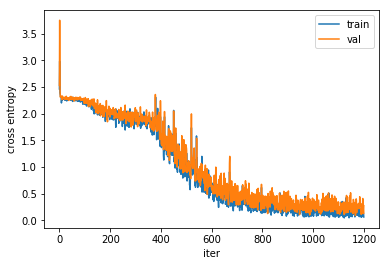

In [127]:
plt.plot(model_1.L_log,label="train")
plt.plot(model_1.L_val_log,label="val")
plt.xlabel("iter")
plt.ylabel("cross entropy")
plt.legend()

今回では、バッチサイズ80で600iterを1エポックとし２エポック学習した。結果、上記グラフの通り、train,valデータ共にcross entropyが低くなり、適切に学習させる事ができた。
600iter(1エポックに相当)である程度下り、あとは飽和しているため、600iter(1エポックに相当)はデータ48000データを学習させればある程度学習させ適切な予測ができると考えられる。
今回はラベル10個（0〜9）なので1ラベルあたり4800で約5000個あれば事足りると思われる。
（このデータセットもこのディープラーニングの学習を見越して適切な枚数のデータを用意しているを推定）

### 【問題8】（アドバンス課題）誤分類の確認
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。



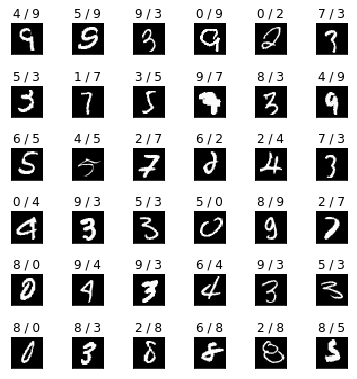

In [128]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

<BarContainer object of 10 artists>

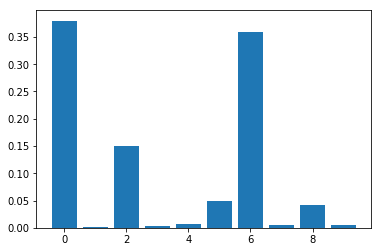

In [129]:
# 正解ラベル：３、予測（確率が最も高い）：２　の予測確率分布の事例
true_false = y_pred!=y_val
plt.bar([i for i in range(10)], pred[1][true_false][4])

予測が間違っているデータ（文字）を確認すると、例えば　”０と９”の共にマルがあるもの　や　”２と７”のようになんとなく形が似ているものである。これらは予測確率を見ると、確かに正解ラベルにもある程度予測の確率はでているが、それ以上に他の間違いやすいラベルに最も高い確率を返している事がわかった。（上記に一事例表示）
機械学習エンジニアは、このような間違いやすい傾向を把握すると共にこの間違いやすい場合にも適切に予測できるアルゴリズムを考えることも必要になってくると考える。